# Probewise normalisations, for the cohort bias correction go [here](http://localhost:8888/notebooks/DEV/GIT/RexR/_hackathon2018/_notebooks/Methylation_cohort_bias_correction.ipynb)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import imputation

from tqdm import tqdm
import gc
from numba import jit
from matplotlib import pyplot as plt

from joblib import Parallel, delayed
import multiprocessing

from time import time
import seaborn as sns

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist

In [2]:
partition_data = False
primary_tumor_only = True
categorize_all = False
cohort_correction = 'combat' # 1. combat: read from file , 2. 

In [3]:
def timeit(method):
    def timed(*args, **kw):
        ts = time()
        result = method(*args, **kw)
        te = time()

        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result

    return timed

def _qn(x, agg='mean'):    
    if agg=='mean':
        @jit
        def _agg(x):
            return np.nanmean(x)
    elif agg=='median':
        @jit
        def _agg(x):
            return np.nanmedian(x)
    @jit
    def __qn(x):
        # assumes column-wise normalisation
        x_sorted = np.empty(x.shape, dtype='float32')
        x_arg_sorted = np.empty(x.shape, dtype='int64')
        x_agg = np.empty(x.shape, dtype='float32')
        x_res = np.empty(x.shape, dtype='float32')

        #print('Sorting probe vectors..')
        for j in range(0, x.shape[1]):
            x_sorted[:,j] = np.sort(x[:, j])
            x_arg_sorted[:,j] = np.argsort(x[:, j])
        #print('Extract agg values per rank..')
        for i in range(0, x.shape[0]):
            x_agg[i,:] = _agg(x_sorted[i,:])
        #print('attach agg values to original rank vectors and unsort')
        for j in range(0, x.shape[1]):
            iv = x_arg_sorted[:,j].astype(int)
            x_res[:,j] = x_agg[:,j][iv]
        return x_res
    
    res = __qn(x)
    return res

def _qn_ref(x, xref, agg='mean'):    
    if agg=='mean':
        @jit
        def _agg(x):
            return np.nanmean(x)
    elif agg=='median':
        @jit
        def _agg(x):
            return np.nanmedian(x)
    @jit
    def __qn(x):
        # assumes column-wise normalisation
        x_sorted = np.empty(x.shape, dtype='float32')
        x_arg_sorted = np.empty(x.shape, dtype='int64')
        x_agg = np.empty(x.shape, dtype='float32')
        x_res = np.empty(x.shape, dtype='float32')

        #print('Sorting probe vectors..')
        for j in range(0, x.shape[1]):
            x_sorted[:,j] = np.sort(x[:, j])
            x_arg_sorted[:,j] = np.argsort(x[:, j])
        #print('Extract agg values per rank..')
        for i in range(0, x.shape[0]):
            x_agg[i,:] = _agg(x_sorted[i,:])
        #print('attach agg values to original rank vectors and unsort')
        for j in range(0, x.shape[1]):
            iv = x_arg_sorted[:,j].astype(int)
            x_res[:,j] = x_agg[:,j][iv]
        return x_res
    
    res = __qn(x)
    return res


In [4]:
def _clean(x, default='float'):   
    non_default = 'int' if default=='float' else 'float'
    try:
        x.replace([np.inf, -np.inf], np.nan, inplace=True)
        x.dropna(how='all', axis=1, inplace=True)
        if default=='float':
            x = x * 1.0
        else:
            x = x * 1
    except Exception as e:
        print(e)
        for col in x.columns:
            if 'object' in str(x[col].dtypes):
                try:
                    x[col] = x[col].astype(default)
                except:
                    try:
                        x[col] = x[col].astype(non_default)
                    except:
                        print(col)
                        x[col] = x[col].astype('category')
    return x

def get_transposed(df, NameRow='GenX', prefix='GenX'):
    transposed  = df.T
    new_index = transposed.loc[[NameRow]].values.tolist()[0]
    transposed.columns = new_index
    if prefix is not None:
        transposed.columns = [prefix+'_'+_col for _col in transposed.columns.values.tolist()]
    return transposed.drop(NameRow, axis=0, inplace=False)

# def _impute(df, type='FM):
#   # use similarity to replace missing values with values for most similar patients.

from sklearn.ensemble import IsolationForest
def _remove_outliers(x, method='isoforest'):
    '''
    x: pandas data frame or numpy array
    method: isoforest 
    '''
    if method=='isoforest': 
        # isolation forest       
        model = IsolationForest(n_estimators=100,)
    
    # consider Angle Based Outlier Detection
    # consider using sample aggregate of z-scores
    return x
    
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence
    
    return True

def _dimension_reduction(x, method='PCA', dimension=3):
    # method: PCA, SAE, UMAP

    return True   
    
                     
def _outliers_modified_z_score(ys, threshold = 3.5):
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return modified_z_scores, np.where(np.abs(modified_z_scores) > threshold)
    

In [5]:
def _qn_apply(df, n_jobs=1, partition='Infinium_Design_Type', qtype='global'):
    pat_cols = [_col for _col in df.columns if 'TCGA-' in _col]   
    groups = df[partition].unique().tolist()
    sel = [_sel for _sel in groups if pd.isnull(_sel)==False]
    cohort_index = df[partition].isin(sel)
    
    df_static = df.copy()[cohort_index]
    df_remain = df.copy()[~cohort_index]
    
    def _quantile(cohort):
        #print('df_static intermediate', df_static.shape)
        ch = df_static[partition]==cohort
        df_temp = df_static[ch].copy()
        tor = df_temp.loc[:, pat_cols]        
        t = tor.T
        if qtype=='global':
            tqn = _qn(t.values)
            df_temp.loc[:, pat_cols] = tqn.T # df_static.loc[ch, pat_cols], df_static[pat_cols][ch], pd.DataFrame(data=tqn.T, index=tor.index, columns=gene_columns)            
        return df_temp
    if n_jobs>1:
        results = Parallel(n_jobs=n_jobs)(delayed(_quantile)(group) for group in sel)
        results += [df_remain]  
        return pd.concat(results)
    else:
        results = []
        for group in tqdm(sel):
            results.append(_quantile(group))
            #print("QN group: {}".format(group))
        results += [df_remain]
        return pd.concat(results)


In [6]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['sample_id'] = pheno_large.index
pheno_large['gender.demographic'] = pheno_large['gender.demographic'].apply(lambda x: 0 
                                                                            if x=='male' else 1 
                                                                                if pd.isna(x)==False 
                                                                                else np.nan)
pheno_large = pheno_large.merge(pd.DataFrame(pheno_large.groupby(by='batch_number').size(), 
                              columns=['batch_size']),
                  left_on='batch_number', right_on='batch_number')

pheno_large = pheno_large.merge(
    pd.DataFrame(pheno_large.groupby(by='batch_number')['gender.demographic']\
                     .mean().reset_index().rename(index=str, columns={'gender.demographic':'gender_mean'})),
                  how='left', left_on='batch_number', right_on='batch_number')

In [7]:
t = pheno_small.groupby(by='PatientID')['Sample Type'].count()
double_patients = t[t>1].index.tolist()
ref_normal_tumor = pheno_small.loc[pheno_small.PatientID.isin(double_patients)][['SampleID', 'Sample Type', 'PatientID']]\
                                            .sort_values(by='SampleID')
pat_cols_primary = list(set(pheno_small.loc[pheno_small['Sample Type'].isin(['Primary Tumor', 'Recurrent Tumor'])]['SampleID']))

In [2]:
root_dir = '/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung'
type_data = pd.read_csv(root_dir+'/HumanMethylation450_meta.csv', engine='c', sep=',',header=7)
type_data['RefGene'] = type_data.UCSC_RefGene_Group.str.split(';').apply(lambda x: 
                                                                         ",".join(sorted(set(x))) 
                                                                         if type(x)==list else np.nan)
rare_refgene = type_data.RefGene.value_counts().index[type_data.RefGene.value_counts()<100].tolist()
type_data['RefGene'][type_data.RefGene.isin(rare_refgene)] = 'uncommon' 
type_data = type_data[['IlmnID', 'Name', 'Infinium_Design_Type', 
                       'Color_Channel', 'Relation_to_UCSC_CpG_Island', 'CHR', 'RefGene']]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
type_data = pd.read_csv(root_dir+'/HumanMethylation450_meta.csv', engine='c', sep=',',header=7)
type_data[['IlmnID', 'Infinium_Design_Type', 'Color_Channel']].to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/MethylationProbeTypes.csv', sep="\t")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
controls = type_data.loc[(type_data.Infinium_Design_Type!='I') & (type_data.Infinium_Design_Type!='II')]

In [9]:
gc.collect()
sourceDir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2" # "/media/bramvanes/Extra/DATA/RexR/2018" #  #"/media/bramvanes/Extra/DATA/RexR/2018" #

methylation_type = 'combat_batch'

if methylation_type=='raw':
    methylation = pd.read_table(sourceDir+"/Lung/Lung_Methylation.txt", sep="\t")
    methylation.set_index('probeID', inplace=True)
elif methylation_type=='combat_batch':
    methylation = pd.read_table(sourceDir+"/Lung/_prepped/methylation_combat_noCovar.csv", sep="\t")
    methylation.rename(index=str, columns={methylation.columns[0]: 'probeID'}, inplace=True)#
    methylation.set_index('probeID', inplace=True)
elif methylation_type=='combat_batch_gender':
    methylation = pd.read_table(sourceDir+"/Lung/_prepped/methylation_combat_genderCovar.csv", sep="\t")
    methylation.rename(index=str, columns={methylation.columns[0]: 'probeID'}, inplace=True)#4
    methylation.set_index('probeID', inplace=True)
elif methylation_type=='combat_batch_gender_target':
    methylation = pd.read_table(sourceDir+"/Lung/_prepped/methylation_combat_genderTargetCovar.csv", sep="\t")
    methylation.rename(index=str, columns={methylation.columns[0]: 'probeID'}, inplace=True)#4
    methylation.set_index('probeID', inplace=True)

In [10]:
methylation= methylation.copy().merge(type_data[['IlmnID',
                                                 'Infinium_Design_Type', 
                                                 'Color_Channel', 
                                                 'Relation_to_UCSC_CpG_Island',
                                                 'CHR',
                                                 'RefGene']], 
                                      how='left', left_index=True, right_on='IlmnID')

In [11]:
pat_cols = list(set([_col for _col in methylation.columns if 'TCGA-' in _col]))
if primary_tumor_only:
    pat_cols =list(set(pat_cols) & set(pat_cols_primary))

In [16]:
num_samples = 25
_cols = ['probeID'] + pat_cols[:num_samples]
boxplot_data = pd.melt(methylation.loc[:,_cols], id_vars='probeID', value_vars = pat_cols[:num_samples], var_name='probe_values')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [17]:
boxplot_data = boxplot_data.copy().merge(pheno_large[['batch_number', 'sample_id']], 
                                         how='left', 
                                         left_on='probe_values', 
                                         right_on='sample_id').drop('sample_id', axis=1)

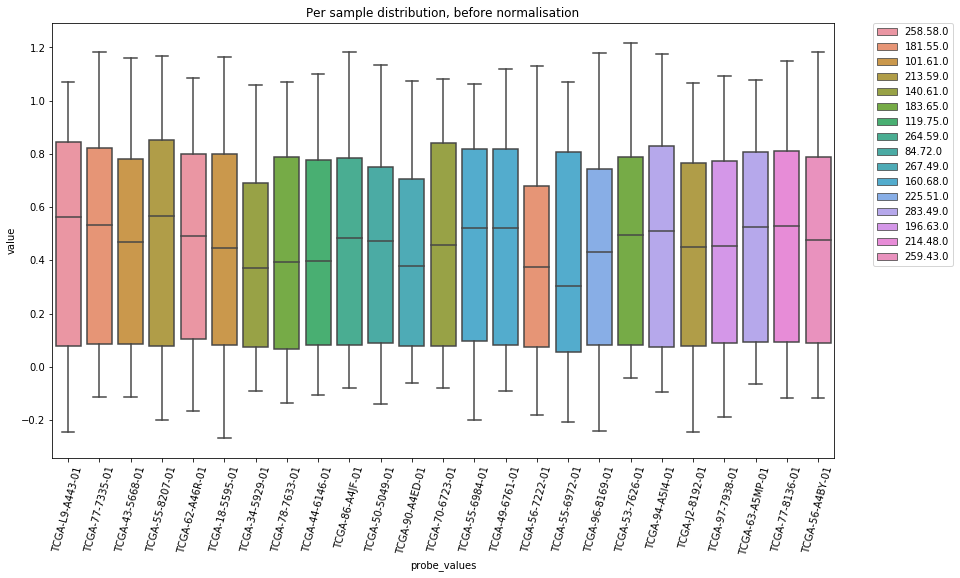

In [18]:
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='probe_values', y='value', data=boxplot_data, hue='batch_number', dodge=False,  ax=ax) # , probe_values
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.set_title('Per sample distribution, before normalisation')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5,1,"NaN's per probe")

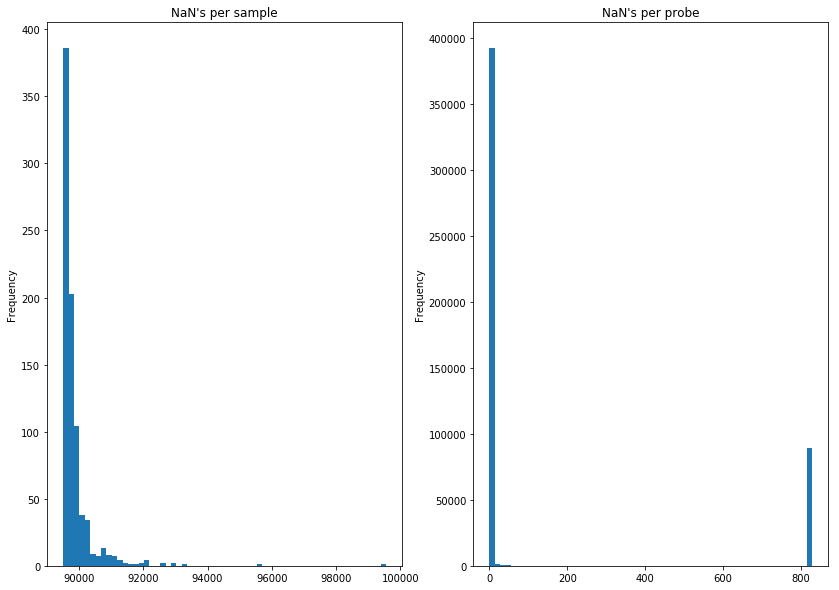

In [15]:
nans_per_sample = methylation.loc[:,pat_cols].isna().sum(axis=0)
nans_per_probe = methylation.loc[:,pat_cols].isna().sum(axis=1)

fig, ax = plt.subplots(figsize=(14,10), ncols=2)
nans_per_sample.plot.hist(bins=60, ax=ax[0])
ax[0].set_title('NaN\'s per sample')

nans_per_probe.plot.hist(bins=60, ax=ax[1])
ax[1].set_title('NaN\'s per probe')

We remove all probes with NaN's in more than $200$ samples, effectively getting rid of the bulk of the NaN's

Text(0.5,1,"NaN's per probe, after filtering")

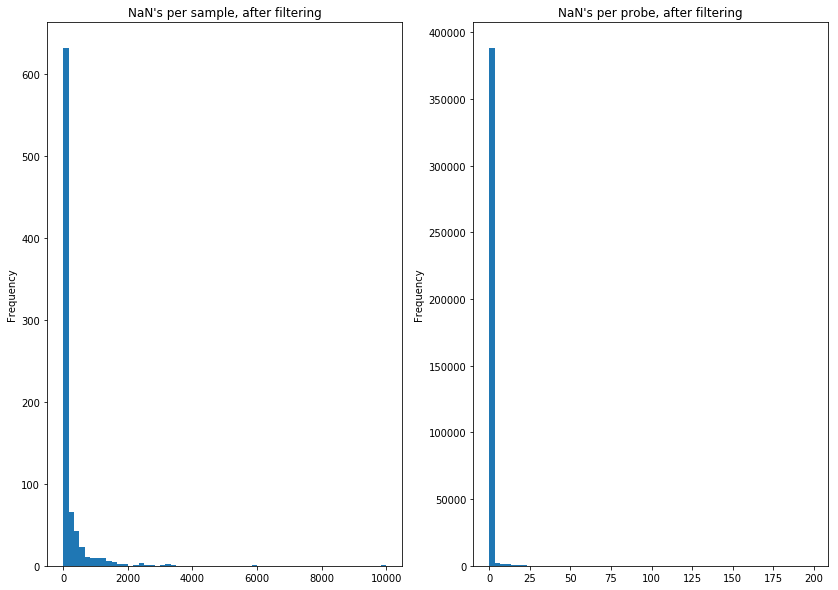

In [16]:
nan_probes = methylation.loc[nans_per_probe[nans_per_probe>200].index.tolist(),:]
methylation = methylation.copy().loc[nans_per_probe[nans_per_probe<200].index.tolist(),:]
gc.collect()

nans_per_sample = methylation.loc[:,pat_cols].isna().sum(axis=0)
nans_per_probe = methylation.loc[:,pat_cols].isna().sum(axis=1)

fig, ax = plt.subplots(figsize=(14,10), ncols=2)
nans_per_sample.plot.hist(bins=60, ax=ax[0])
ax[0].set_title('NaN\'s per sample, after filtering')

nans_per_probe.plot.hist(bins=60, ax=ax[1])
ax[1].set_title('NaN\'s per probe, after filtering')

## check for collinearity 

In [70]:
corr_meth = methylation.loc[:,pat_cols].corr(method="pearson")

In [21]:
(corr_meth>0.99).sum().sum()/(corr_meth.shape[0]*corr_meth.shape[1])*100

0.12135288140513864

**99**% of the feature columns have a Pearson correlation higher than *0.75*. We choose to remove the samples that are correlated for more  than **99%** with at least one other sample vector to keep any matrix inverson well-behaved.

In [71]:
t_coll = corr_meth.columns[(corr_meth>0.99).sum()>1].tolist()

In [32]:
t_coll = ['TCGA-56-8623-01', 'TCGA-L4-A4E6-01', 'TCGA-55-8513-01', 'TCGA-99-AA5R-01', 'TCGA-86-A4P8-01']

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif(X, thresh=5.0, n_jobs=4):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=n_jobs,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

In [72]:
corr_meth.loc[t_coll, t_coll]

,TCGA-56-8623-01,TCGA-L4-A4E6-01,TCGA-55-8513-01,TCGA-99-AA5R-01,TCGA-86-A4P8-01
TCGA-56-8623-01,1.000000,0.990171,0.982972,0.981196,0.986071
TCGA-L4-A4E6-01,0.990171,1.000000,0.982963,0.984200,0.986835
TCGA-55-8513-01,0.982972,0.982963,1.000000,0.987380,0.990488
TCGA-99-AA5R-01,0.981196,0.984200,0.987380,1.000000,0.990543
TCGA-86-A4P8-01,0.986071,0.986835,0.990488,0.990543,1.000000


In [ ]:
coll_meth = calculate_vif(methylation, thresh=5.0, n_jobs=1)

919


In [33]:
methylation_Transpose = methylation.loc[:, pat_cols].T
methylation_Transpose.columns = methylation.IlmnID
#methylation_Transpose.dropna(axis=1, thresh=100, inplace=True)
methylation_Transpose = methylation_Transpose.copy().merge(pheno_large[['batch_number', 'sample_id']], 
                            how='inner',
                            left_index=True, 
                            right_on='sample_id').drop('sample_id', axis=1)

In [34]:
batches  = methylation_Transpose.batch_number.unique().tolist()
prob_cols = [_col for _col in methylation_Transpose.columns if 'batch' not in _col] 

In [151]:
methylation_Transpose_by_batch = methylation_Transpose.copy().groupby('batch_number').mean().T
methylation_Transpose_by_batch['probe'] = methylation_Transpose_by_batch.index

In [205]:
num_batches = 38
_cols = ['probe'] + batches[:num_batches]
boxplot_data = pd.melt(methylation_Transpose_by_batch.loc[:,_cols], 
                       id_vars='probe', value_vars = batches[:num_batches], var_name='batch_number')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [20]:
df1 = pheno_large.groupby('batch_number')['number_pack_years_smoked'].agg(['mean', 'count'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'smoke_years',
                                                                                             'count': 'batch_size'})

df2 = pheno_large.groupby('batch_number')['cigarettes_per_day.exposures'].agg(['mean'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'cigs_per_days'})

df3 = pheno_large.groupby('batch_number')['age_at_initial_pathologic_diagnosis'].agg(['mean'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'age'})

df4 = pheno_large.groupby('batch_number')['gender.demographic'].agg(['mean'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'gender'})

In [21]:
dff = df1.merge(df2, how='inner', left_on='batch_number', right_on='batch_number')
dff = dff.copy().merge(df3, how='inner', left_on='batch_number', right_on='batch_number')
dff = dff.copy().merge(df4, how='inner', left_on='batch_number', right_on='batch_number')

In [22]:
boxplot_data = boxplot_data.copy().merge(dff, how='inner', left_on='batch_number', right_on='batch_number')

In [23]:
_tmp = boxplot_data.groupby(by='batch_number').value.agg(['mean', 'median']).reset_index().rename(index=str, 
                                                                                          columns={'mean':'mean_val',
                                                                                                  'median': 'median_val'})
boxplot_data = boxplot_data.copy().merge(_tmp, how='inner', left_on='batch_number', right_on='batch_number')
del _tmp
gc.collect()

68

In [24]:
_tmp = boxplot_data[boxplot_data.value>=0.5].groupby(by='batch_number').value.agg(['mean', 'median']).reset_index().rename(index=str, 
                                                                                          columns={'mean':'mean_val_up',
                                                                                                  'median': 'median_val_up'})
boxplot_data = boxplot_data.copy().merge(_tmp, how='inner', left_on='batch_number', right_on='batch_number')
del _tmp
gc.collect()

_tmp = boxplot_data[boxplot_data.value<0.5].groupby(by='batch_number').value.agg(['mean', 'median']).reset_index().rename(index=str, 
                                                                                          columns={'mean':'mean_val_down',
                                                                                                  'median': 'median_val_down'})
boxplot_data = boxplot_data.copy().merge(_tmp, how='inner', left_on='batch_number', right_on='batch_number')
del _tmp
gc.collect()

63

Text(0.5,1,'Per cohort distribution of mean probe values, before normalisation')

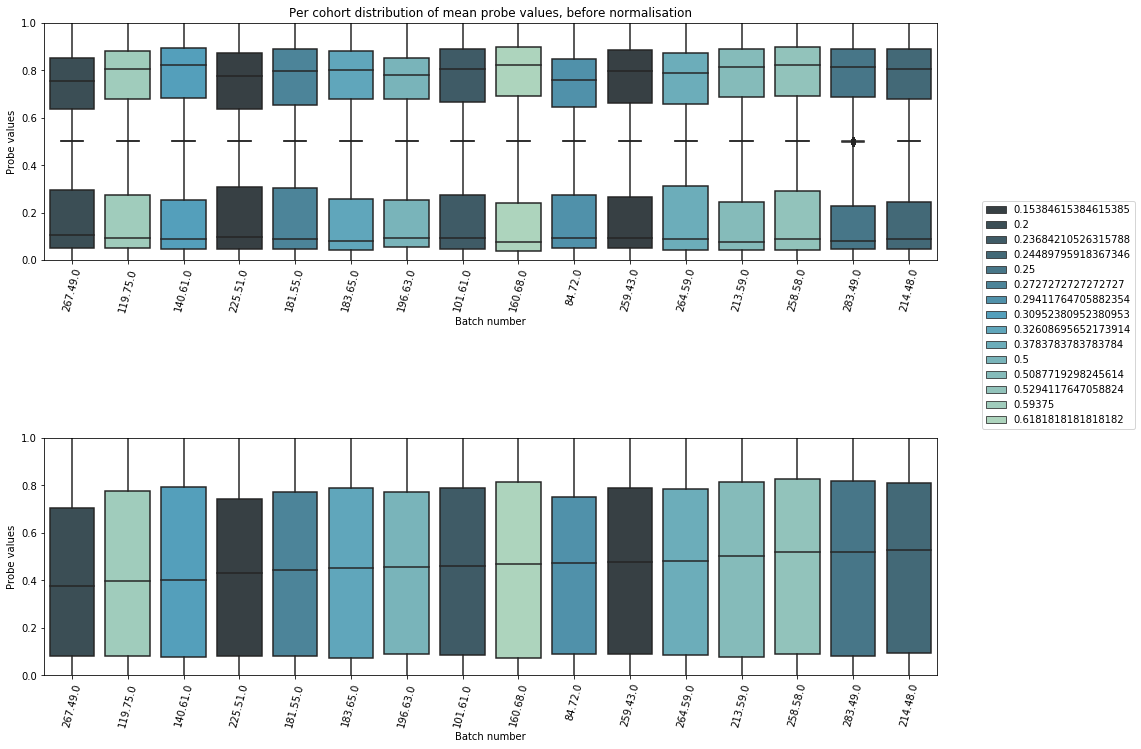

In [30]:
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
phenotype = 'gender'

boxplot_data.sort_values(by='median_val', inplace=True)
sns.boxplot(x='batch_number', 
            y='value',
            data=boxplot_data.loc[boxplot_data.value>=0.5],
            dodge=False, 
            hue=phenotype, 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[0]) # , probe_values
#
boxplot_data.sort_values(by='median_val', inplace=True)
sns.boxplot(x='batch_number', 
            y='value',
            data=boxplot_data.loc[boxplot_data.value<0.5],
            dodge=False, 
            hue=phenotype, 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[0]) # , probe_values
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=75)
ax[0].get_legend().remove()
ax[0].set_xlabel('Batch number')
ax[0].set_ylabel('Probe values')
ax[0].set_ylim(0,1)
#
boxplot_data.sort_values(by='median_val', inplace=True)
sns.boxplot(x='batch_number', 
            y='value',
            data=boxplot_data,
            dodge=False, 
            hue=phenotype, 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[1]) # , probe_values
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=75)
ax[1].legend(bbox_to_anchor=(1.05, 2), loc=2, borderaxespad=0.)
ax[1].set_xlabel('Batch number')
ax[1].set_ylabel('Probe values')
ax[1].set_ylim(0,1)

fig.subplots_adjust(hspace=0.75)
ax[0].set_title('Per cohort distribution of mean probe values, before normalisation')


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


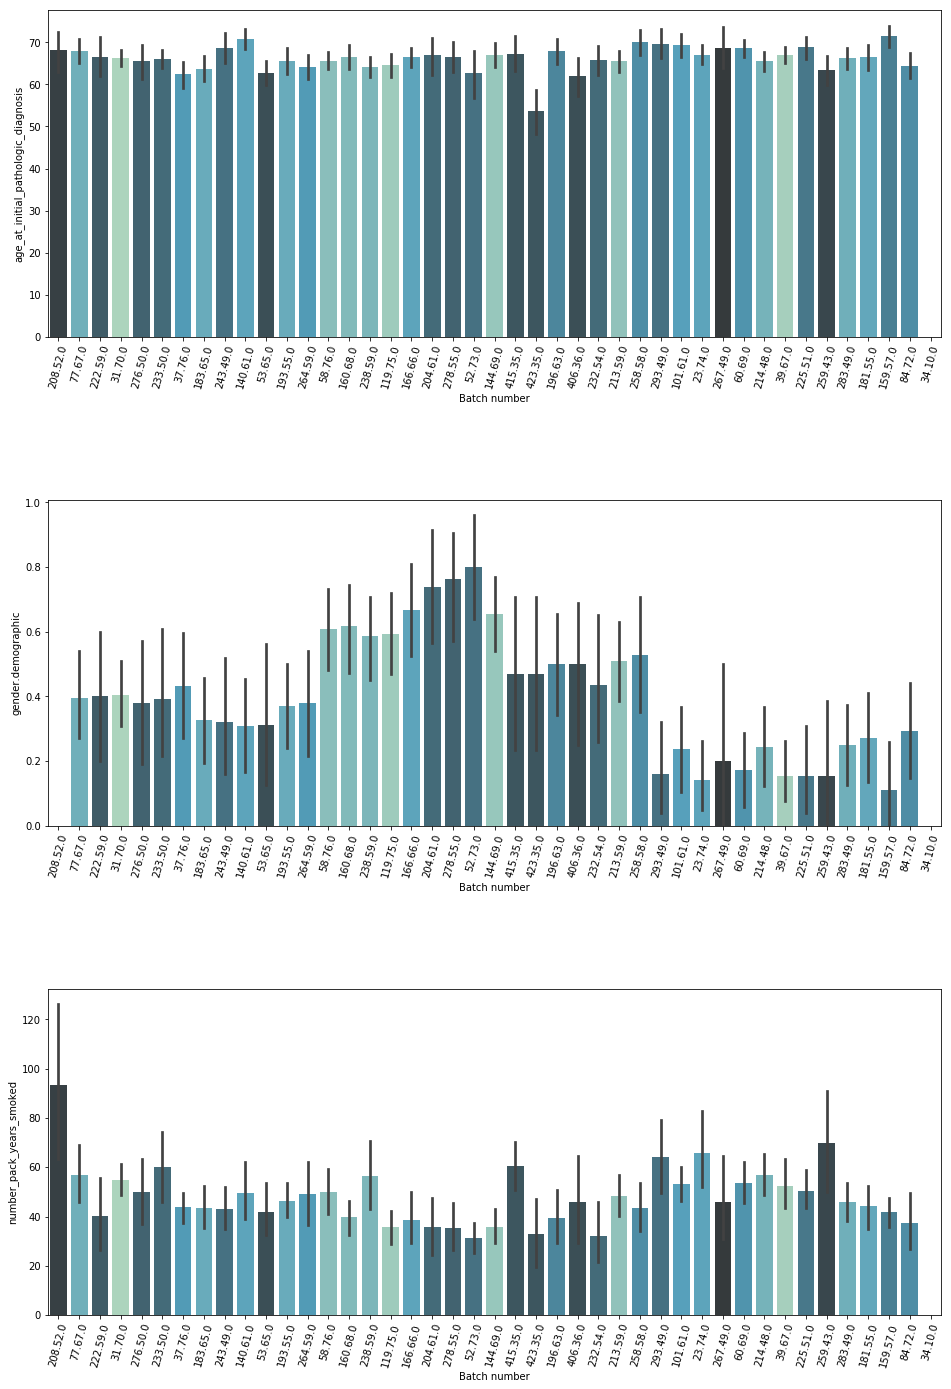

In [499]:
# plot's of phenotypical values over cohorts
fig, ax = plt.subplots(nrows=3, figsize=(16,24))
phenotypes = ['age_at_initial_pathologic_diagnosis', 
              'gender.demographic', # gender_mean
              'number_pack_years_smoked', 
              'cigarettes_per_day.exposures']

pheno_large.sort_values(by=phenotypes[1], inplace=True)

sns.barplot(x='batch_number', 
            y=phenotypes[0],
            data=pheno_large,
            dodge=False, 
            hue='batch_size', 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[0]) # , probe_values
#
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=75)
ax[0].get_legend().remove()
ax[0].set_xlabel('Batch number')
ax[0].set_ylabel(phenotypes[0])
#
sns.barplot(x='batch_number', 
            y=phenotypes[1],
            data=pheno_large,
            dodge=False, 
            hue='batch_size', 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[1]) # , probe_values
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=75)
ax[1].get_legend().remove()
ax[1].set_xlabel('Batch number')
ax[1].set_ylabel(phenotypes[1])
#
sns.barplot(x='batch_number', 
            y=phenotypes[2],
            data=pheno_large,
            dodge=False, 
            hue='batch_size', 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[2]) # , probe_values
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=75)
ax[2].get_legend().remove()
ax[2].set_xlabel('Batch number')
ax[2].set_ylabel(phenotypes[2])
#

fig.subplots_adjust(hspace=0.5)
#ax[0].set_title('Per cohort distribution of mean probe values, before normalisation')

In [500]:
# significances of differences between pheno's.
tot_res = []
for _phenotype in phenotypes:    
    res = []
    for _batch_nr in batches:
        _all = pheno_large.loc[pheno_large.batch_number!=_batch_nr][_phenotype]
        _batch = pheno_large.loc[pheno_large.batch_number==_batch_nr][_phenotype]
        _ks = ks2(_all.values, _batch.values)
        _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
        try:
            _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
        except ValueError as e:
            print('ValError, defaulting to NaN')
            _w1 = _w2 = np.nan
        
        res.append({'batch_number': _batch_nr,
                    'ks_stat': _ks[0], 'ks_p': _ks[1],
                    'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                    'w1_dist': _w1, 'w2_dist': _w2})
    res_df = pd.DataFrame(res)
    tot_res.append(res_df)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4775: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / (1.0*n2)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4780: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


ValError, defaulting to NaN
ValError, defaulting to NaN
ValError, defaulting to NaN
ValError, defaulting to NaN


p=0.01->4 cohorts, p=0.05->13 cohorts


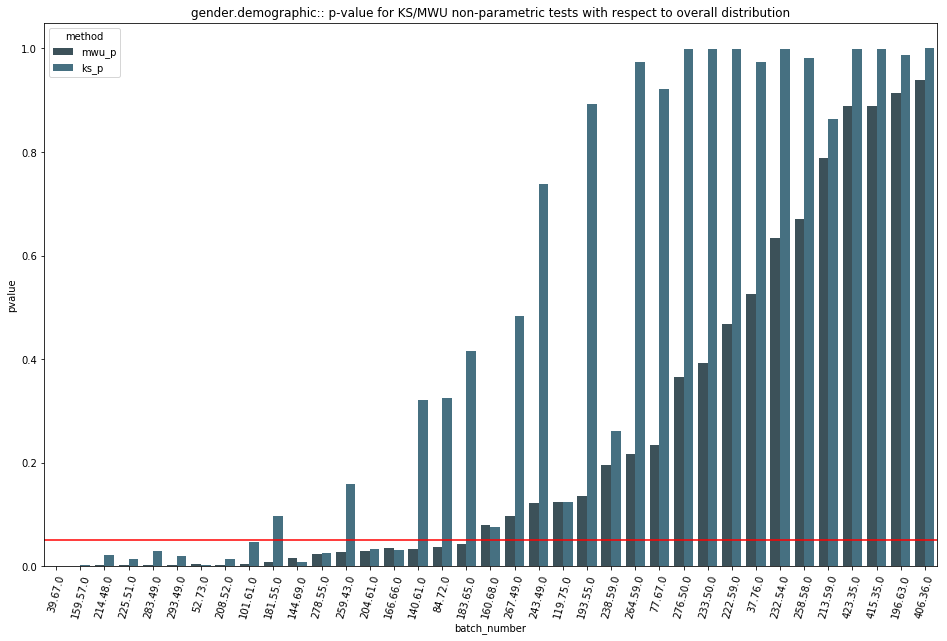

In [502]:
fig, ax = plt.subplots(figsize=(16,10))
idx = 1
barplot_data = pd.melt(tot_res[idx][['batch_number', 'ks_p', 'mwu_p']],
                       id_vars='batch_number',
                       value_vars=['ks_p', 'mwu_p'],
                       value_name='pvalue',
                       var_name='method')
barplot_data.sort_values(by='pvalue', inplace=True)
sns.barplot(x='batch_number', y='pvalue', hue='method', data=barplot_data, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.axhline(0.05, color='red')
ax.set_title("{}:: p-value for KS/MWU non-parametric tests with respect to overall distribution".format(phenotypes[idx]))

print("p=0.01->{} cohorts, p=0.05->{} cohorts".format((tot_res[idx]['ks_p']<0.01).sum(), 
                                                      (tot_res[idx]['ks_p']<0.05).sum()))


Looking at the p-values for the Kolmogorov-Smirnof and Mann-Whitney U tests we find that most of the cohorts are not significantly different from the bulk distribution for age and number of smokes cigarettes. 

In [17]:
# The inter-cohort distribution of mean/median

In [18]:
# SSinter, SSintra

Before we even embark on the removal of cohort bias we should wonder whether the inter-cohort differences are not explainable with the phenotypical differences between the cohorts.

It seems that the age, gender and number of smoked cigarettes varies strongly between the different cohorts.
On the one hand this discourages the use of cohort bias correction as we might falsely remove variance, in the sense
that instead of reducing bias we simply remove signal. On the other hand, given that phenotypical differences differ significantly between the cohorts we might amplify or weaken these difference due to actual cohort measurement biases. Another question is, given the high variance of phenotypical values, can we even identify cohort biases?

We could look at the biological groups (age, gender, clinical history, etc.) and use their probe distributions as 
the reference distributions perhaps? The same for the sample types (normal, tumor, solid), site Of resection, tumor location etc. and the group each specific probe belongs to (type I/II, color).

The ComBat (implemented in R) method takes the covariates into account, as do the RUV methods (m, inverse) and the SubsetQN/SmoothedQN methods.

A note with ComBat: it only only takes categorical covariates into account. Hence, to apply ComBat to
numerical covariates we need to apply binning. 

As the covariates for the cohort bias correction :
* Years exposed to smoke/amount smoked
* Age
* Sample type
* ...
* diagnosis
* Gender
* Tissue source site

We do not touch upon the discussion to impute the missing values for phenotypes and instead simply pick the phenotypes for which values were available for all samples. Where only the latter three (diagnosis, gender and tissue source site) are available for all samples. ComBat requires that the covariants vary within the cohorts, which further limits our selection such that we are left with **gender** as the only covariant besides the batch number.

We can however use imputation to complete the data for the age and the cigarettes smoked. We do this simply by taking the median. This results in $3$ covariates: *gender*, *age*, *packs smoked per day*.

In [26]:
_covariates = ['age_at_initial_pathologic_diagnosis',
               'histological_type',
                'years_smoked.exposures',
                'number_pack_years_smoked',
                'gender.demographic',
                'tissue_source_site',
                'sample_type.samples',
                'vial_number',
                'diagnosis']

methylation_meta = pheno_large[['sample_id', 
                                'batch_number'
                                ]+_covariates]
methylation_meta.rename(index=str, columns={'batch_number': 'Batch',
                                            'sample_id': 'Sample name'}, inplace=True)
# create bins 
if (categorize_all==True):
    base_term = 'smoke_exposure_years'
    _bins = 5
    name_list = [base_term+"_"+str(i) for i in range(0,_bins)]
    methylation_meta.loc[:, 'cat_smoke_years'] = pd.qcut(methylation_meta['years_smoked.exposures'], q=_bins, labels=name_list)
    methylation_meta.loc[:, 'cat_smoke_years'] = methylation_meta['cat_smoke_years'].cat.add_categories('Unknown').fillna('Unknown')

    base_term = 'age'
    _bins = 5
    name_list = [base_term+"_"+str(i) for i in range(0,_bins)]
    methylation_meta.loc[:, 'cat_age'] = pd.qcut(methylation_meta['age_at_initial_pathologic_diagnosis'], q=_bins, labels=name_list)
    methylation_meta.loc[:,'cat_age'] = methylation_meta['cat_age'].cat.add_categories('Unknown').fillna('Unknown')

    base_term = 'number_of_packs'
    _bins = 5
    name_list = [base_term+"_"+str(i) for i in range(0,_bins)]
    methylation_meta.loc[:,'cat_packs'] = pd.qcut(methylation_meta['number_pack_years_smoked'], q=_bins, labels=name_list)
    methylation_meta.loc[:,'cat_packs'] = methylation_meta['cat_packs'].cat.add_categories('Unknown').fillna('Unknown')
    methylation_meta['cat_histo'] = methylation_meta['histological_type']
else:
    methylation_meta['cat_smoke_years'] = methylation_meta['years_smoked.exposures']
    methylation_meta['cat_age'] = methylation_meta['age_at_initial_pathologic_diagnosis']
    methylation_meta['cat_packs'] = methylation_meta['number_pack_years_smoked']
    methylation_meta['cat_histo'] = methylation_meta['histological_type']

methylation_meta.loc[:,'cat_diagnosis'] = methylation_meta['diagnosis'].astype('category')
methylation_meta.loc[:,'cat_vial_number'] = methylation_meta['vial_number'].astype('category')

methylation_meta.loc[:,'cat_gender'] = methylation_meta['gender.demographic'].astype('category')
methylation_meta.loc[:,'cat_source_site'] = methylation_meta['tissue_source_site'].astype('category')
methylation_meta.loc[:,'cat_sample_type'] = methylation_meta['sample_type.samples'].astype('category')

methylation_meta.drop(_covariates, axis=1, inplace=True)

methylation_meta['Array name'] = methylation_meta['Sample name']

methylation_meta.set_index('Array name', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

## imputance

We still have NaN's in the probe values. To impute them we 
apply 
* factorisation machines OR
* quantile normalisation OR
* a regressor per probe OR
* the mean per cohort, the mean per biological group OR
* **we simply remove the probes with NaN's**.

Should the phenotypical data also be imputed? How? 

In [29]:
max_nans_per_probe = 0
nan_probe_list = nans_per_probe[nans_per_probe<=max_nans_per_probe].index

In [34]:
pat_cols = list(set(pat_cols)-set(t_coll))
methylation_meta_combat = methylation_meta.loc[methylation_meta['Sample name'].isin(pat_cols),:]
methylation_meta_combat.drop_duplicates(subset='Sample name', keep='first', inplace=True)
met_pat_list = methylation_meta_combat.loc[methylation_meta_combat.index.isin(pat_cols)].index.tolist()
methylation_meta_combat.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/methylation_combat_meta_small_cont.csv",
                            index=True, header=True, sep="\t")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
methylation.loc[nan_probe_list,met_pat_list].to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/methylation_raw_"+str(max_nans_per_probe)+"nanmax.csv",
                            index=True, header=True, sep="\t")

In [108]:
(methylation.loc[nan_probe_list,met_pat_list].T).to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/methylation_transposed.csv",
                            index=True, header=False, sep="\t")

In [ ]:
#M-value scale,  relative log expression (RLE), deviation from median expression level before normalisation, 
# per sample, colored by cohort. M = log2(beta/(beta-1))

# Normalisation per cohort

Before we quantile normalise over the *probe groups* (i.e. probe wise/column wise) we should 
remove any batch effects over the *patient groups* (i.e. patient wise per probe/row wise). 

For the methylation data we can apply the following global adjustment methods
* Quantile Normalisation over the cohorts with the global distribution as a reference, for different sample groups
* ComBat (L/S + Empirical Bayes)
* L/S standard

A more recent method called RUV-2/RUV-inverse could not be applied because we do not have the negative control probes available. Arguably we can apply RUV(-2)/RUV-inverse using the Type I probe values as is done with Subset QN but we consider this out of scope for this paper.

Following this step we apply a probewise normalisation
* Global QN 
* Global QN per Type
* Subset Quantile normalisation with Type I probes as the reference

The SQN method can be applied with Type I probes per distinct group: e.g. relation tp CpG, relation to gene sequence, etc. To further limit the reference probes to the most expressive signals we can select only those probes that are distinct from the other probes with some significance level.

Sanity check: plot median beta's over the samples.

# Probewise normalisation

In [12]:
del type_data
gc.collect()

42

In [37]:
#methylation.set_index('probeID', inplace=True)    
#methylation = methylation.drop(['IlmnID', 'Gene', 'Chr', 
#                                    'Start', 'Stop', 'Strand', 'Color_Channel', 'Infinium_Design_Type',
#                                    'Relation_to_UCSC_CpG_Island', 'RefGene', 'CHR'], axis=1) 


def probewise_GQN(data, pat_cols, batches, targets, probe_group_col, njobs=1):    
    # cohort is batch_col then target_val
    #list(batch.values())[0]
    groups = data[probe_group_col].unique().tolist()
    res = pd.DataFrame()
    for jdx, pohort in enumerate(groups):
        print("+"*30, "Processing pohort {} of {}".format(jdx, len(groups)))
        _res = pd.DataFrame() # columns=pat_cols, index=data.index
        for idx, batch in enumerate(batches):
            print("++"*30, "Processing batch {} of {}".format(idx, len(batches)))
            _pats = list(set(list(batch.values())[0]) & set(pat_cols))           
            for target in targets:
                __pats = list(set(list(target.values())[0]) & set(pat_cols))
                pats = set(_pats) & set(__pats)
                # pohort is group in probe_group_col
                sub_data = data.loc[data[probe_group_col]==pohort, pats]
                __res = pd.DataFrame(data=_qn(sub_data.values), 
                              index=sub_data.index, columns=sub_data.columns)
                _res = pd.concat([_res, __res], axis=1)
                del __res
                gc.collect()
            gc.collect()
            print(":"*20,"Size of dataframe for batch {} is {}".format(idx, _res.shape))
        res = pd.concat([res, _res], axis=0)
        del _res 
        gc.collect()
    return res



In [13]:
batch_cols = pheno_large.batch_number.unique().tolist()
batches = [{_batch: pheno_large.loc[pheno_large.batch_number==_batch].sample_id.tolist()} for _batch in batch_cols]

In [14]:
diags = pheno_small.Diagnosis.unique().tolist()
targets = [{_diag: pheno_small.loc[pheno_small.Diagnosis==_diag].SampleID.tolist()} for _diag in diags]

In [53]:
type_data['Relation_to_UCSC_CpG_Island'] = type_data['Relation_to_UCSC_CpG_Island'].fillna('unknown')
type_data['RefGene'] = type_data['RefGene'].fillna('unknown')

Overall percentage of type I is 27.856332283503416%


/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


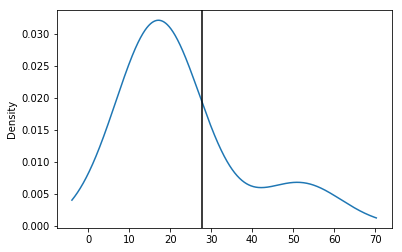

In [41]:
# how well are infinium types distributed over the subgroups
rel_type1 = 100*(type_data.Infinium_Design_Type=='I').sum()/type_data.shape[0]
print('Overall percentage of type I is {}%'.format(rel_type1))
temp = type_data.groupby(by=['Relation_to_UCSC_CpG_Island']).agg({'Infinium_Design_Type': 
                                          {'rel_count': lambda x: 100*sum(x=='I')/len(x)}
                                      })
temp.Infinium_Design_Type.rel_count.plot.kde()
plt.axvline(rel_type1, color='black')

We decide to perform the QN per target, per batch and per the following probe groups: Inf-type, Reference gene, CpG island and Chromosome. 

In [56]:
methylation.set_index('IlmnID', inplace=True)

In [42]:
pat_cols = [_col for _col in methylation.columns if 'TCGA-' in _col]  
probe_group_col = 'Infinium_Design_Type' # Relation_to_UCSC_CpG_Island Infinium_Design_Type RefGene
batch_col = 'batch_number' # batchwise..
target_col = 'Diagnosis' # batchwise 

print("Processing Inftype QN")
corrected = {'Infinium_Design_Type': 
             probewise_GQN(methylation, pat_cols, batches, targets, probe_group_col)}

print("Processing RefGene QN")
probe_group_col = 'RefGene' # Relation_to_UCSC_CpG_Island Infinium_Design_Type
corrected['RefGene'] = probewise_GQN(methylation, pat_cols, batches, targets, probe_group_col)

print("Processing Relation_to_UCSC_CpG_Island QN")
probe_group_col = 'Relation_to_UCSC_CpG_Island' # Relation_to_UCSC_CpG_Island Infinium_Design_Type
corrected['Relation_to_UCSC_CpG_Island'] = probewise_GQN(methylation, pat_cols, batches, targets, probe_group_col)

print("Processing Chromosome QN")
probe_group_col = 'CHR' # Relation_to_UCSC_CpG_Island Infinium_Design_Type
corrected['CHR'] = probewise_GQN(methylation, pat_cols, batches, targets, probe_group_col)


Processing Inftype QN
++++++++++++++++++++++++++++++ Processing pohort 0 of 2
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
:::::::::::::::::::: Size of dataframe for batch 0 is (257762, 30)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 1 of 43
:::::::::::::::::::: Size of dataframe for batch 1 is (257762, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 2 of 43
:::::::::::::::::::: Size of dataframe for batch 2 is (257762, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (257762, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (257762, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (257762, 79)
++++

:::::::::::::::::::: Size of dataframe for batch 9 is (108015, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (108015, 191)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 11 of 43
:::::::::::::::::::: Size of dataframe for batch 11 is (108015, 210)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 12 of 43
:::::::::::::::::::: Size of dataframe for batch 12 is (108015, 258)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 13 of 43
:::::::::::::::::::: Size of dataframe for batch 13 is (108015, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (108015, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (108015, 3

:::::::::::::::::::: Size of dataframe for batch 19 is (0, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (0, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (0, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 22 of 43
:::::::::::::::::::: Size of dataframe for batch 22 is (0, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 23 of 43
:::::::::::::::::::: Size of dataframe for batch 23 is (0, 402)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 24 of 43
:::::::::::::::::::: Size of dataframe for batch 24 is (0, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (0, 463)
++++++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 30 is (12563, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (12563, 588)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 32 of 43
:::::::::::::::::::: Size of dataframe for batch 32 is (12563, 625)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 33 of 43
:::::::::::::::::::: Size of dataframe for batch 33 is (12563, 660)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 34 of 43
:::::::::::::::::::: Size of dataframe for batch 34 is (12563, 669)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 35 of 43
:::::::::::::::::::: Size of dataframe for batch 35 is (12563, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (12563, 720)
++

:::::::::::::::::::: Size of dataframe for batch 40 is (7962, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (7962, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (7962, 825)
++++++++++++++++++++++++++++++ Processing pohort 3 of 36
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
:::::::::::::::::::: Size of dataframe for batch 0 is (40648, 30)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 1 of 43
:::::::::::::::::::: Size of dataframe for batch 1 is (40648, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 2 of 43
:::::::::::::::::::: Size of dataframe for batch 2 is (40648, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size 

:::::::::::::::::::: Size of dataframe for batch 7 is (37742, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (37742, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (37742, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (37742, 191)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 11 of 43
:::::::::::::::::::: Size of dataframe for batch 11 is (37742, 210)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 12 of 43
:::::::::::::::::::: Size of dataframe for batch 12 is (37742, 258)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 13 of 43
:::::::::::::::::::: Size of dataframe for batch 13 is (37742, 279)
+++++++

:::::::::::::::::::: Size of dataframe for batch 17 is (112140, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (112140, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (112140, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (112140, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (112140, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 22 of 43
:::::::::::::::::::: Size of dataframe for batch 22 is (112140, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 23 of 43
:::::::::::::::::::: Size of dataframe for batch 23 is (112140, 

:::::::::::::::::::: Size of dataframe for batch 27 is (18649, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (18649, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (18649, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (18649, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (18649, 588)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 32 of 43
:::::::::::::::::::: Size of dataframe for batch 32 is (18649, 625)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 33 of 43
:::::::::::::::::::: Size of dataframe for batch 33 is (18649, 660)
++

:::::::::::::::::::: Size of dataframe for batch 37 is (15737, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (15737, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (15737, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (15737, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (15737, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (15737, 825)
++++++++++++++++++++++++++++++ Processing pohort 8 of 36
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
::::::::::::::

:::::::::::::::::::: Size of dataframe for batch 4 is (543, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (543, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (543, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (543, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (543, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (543, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (543, 191)
+++++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 15 is (2295, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (2295, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (2295, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (2295, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (2295, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (2295, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (2295, 369)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 25 is (3712, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (3712, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (3712, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (3712, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (3712, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (3712, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (3712, 588)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 35 is (2617, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (2617, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (2617, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (2617, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (2617, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (2617, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (2617, 825)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 2 is (1673, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (1673, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (1673, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (1673, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (1673, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (1673, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (1673, 132)
++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 13 is (3631, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (3631, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (3631, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (3631, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (3631, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (3631, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (3631, 351)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 24 is (771, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (771, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (771, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (771, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (771, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (771, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (771, 560)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 35 is (2279, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (2279, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (2279, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (2279, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (2279, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (2279, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (2279, 825)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 2 is (975, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (975, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (975, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (975, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (975, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (975, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (975, 132)
+++++++++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 13 is (484, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (484, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (484, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (484, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (484, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (484, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (484, 351)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 24 is (1167, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (1167, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (1167, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (1167, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (1167, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (1167, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (1167, 560)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 35 is (496, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (496, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (496, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (496, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (496, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (496, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (496, 825)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 3 is (452, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (452, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (452, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (452, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (452, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (452, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (452, 155)
++++++++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 14 is (1944, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (1944, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (1944, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (1944, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (1944, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (1944, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (1944, 362)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 25 is (615, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (615, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (615, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (615, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (615, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (615, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (615, 588)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 36 is (80, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (80, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (80, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (80, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (80, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (80, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (80, 825)
+++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 4 is (109, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (109, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (109, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (109, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (109, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (109, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (109, 191)
+++++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 15 is (262, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (262, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (262, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (262, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (262, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (262, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (262, 369)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 26 is (410, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (410, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (410, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (410, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (410, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (410, 588)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 32 of 43
:::::::::::::::::::: Size of dataframe for batch 32 is (410, 625)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 37 is (346, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (346, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (346, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (346, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (346, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (346, 825)
++++++++++++++++++++++++++++++ Processing pohort 33 of 36
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
:::::::::::::::::::: Size

:::::::::::::::::::: Size of dataframe for batch 5 is (373, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (373, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (373, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (373, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (373, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (373, 191)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 11 of 43
:::::::::::::::::::: Size of dataframe for batch 11 is (373, 210)
++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 16 is (106, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (106, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (106, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (106, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (106, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (106, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 22 of 43
:::::::::::::::::::: Size of dataframe for batch 22 is (106, 369)
++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 26 is (36819, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (36819, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (36819, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (36819, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (36819, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (36819, 588)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 32 of 43
:::::::::::::::::::: Size of dataframe for batch 32 is (36819, 625)
++

:::::::::::::::::::: Size of dataframe for batch 37 is (0, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (0, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (0, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (0, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (0, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (0, 825)
++++++++++++++++++++++++++++++ Processing pohort 2 of 6
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
:::::::::::::::::::: Size of dataframe 

:::::::::::::::::::: Size of dataframe for batch 4 is (134570, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (134570, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (134570, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (134570, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (134570, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (134570, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (134570, 191)
++++++++

:::::::::::::::::::: Size of dataframe for batch 14 is (13773, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (13773, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (13773, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (13773, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (13773, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (13773, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (13773, 362)
++

:::::::::::::::::::: Size of dataframe for batch 24 is (15581, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (15581, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (15581, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (15581, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (15581, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (15581, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (15581, 560)
++

:::::::::::::::::::: Size of dataframe for batch 34 is (3618, 669)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 35 of 43
:::::::::::::::::::: Size of dataframe for batch 35 is (3618, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (3618, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (3618, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (3618, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (3618, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (3618, 803)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 1 is (11428, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 2 of 43
:::::::::::::::::::: Size of dataframe for batch 2 is (11428, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (11428, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (11428, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (11428, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (11428, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (11428, 103)
++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 11 is (17035, 210)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 12 of 43
:::::::::::::::::::: Size of dataframe for batch 12 is (17035, 258)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 13 of 43
:::::::::::::::::::: Size of dataframe for batch 13 is (17035, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (17035, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (17035, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (17035, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (17035, 319)
++

:::::::::::::::::::: Size of dataframe for batch 21 is (11608, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 22 of 43
:::::::::::::::::::: Size of dataframe for batch 22 is (11608, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 23 of 43
:::::::::::::::::::: Size of dataframe for batch 23 is (11608, 402)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 24 of 43
:::::::::::::::::::: Size of dataframe for batch 24 is (11608, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (11608, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (11608, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (11608, 493)
++

:::::::::::::::::::: Size of dataframe for batch 31 is (7442, 588)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 32 of 43
:::::::::::::::::::: Size of dataframe for batch 32 is (7442, 625)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 33 of 43
:::::::::::::::::::: Size of dataframe for batch 33 is (7442, 660)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 34 of 43
:::::::::::::::::::: Size of dataframe for batch 34 is (7442, 669)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 35 of 43
:::::::::::::::::::: Size of dataframe for batch 35 is (7442, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (7442, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (7442, 754)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 41 is (19796, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (19796, 825)
++++++++++++++++++++++++++++++ Processing pohort 7 of 26
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
:::::::::::::::::::: Size of dataframe for batch 0 is (26844, 30)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 1 of 43
:::::::::::::::::::: Size of dataframe for batch 1 is (26844, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 2 of 43
:::::::::::::::::::: Size of dataframe for batch 2 is (26844, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (26844, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size 

:::::::::::::::::::: Size of dataframe for batch 8 is (18461, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (18461, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (18461, 191)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 11 of 43
:::::::::::::::::::: Size of dataframe for batch 11 is (18461, 210)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 12 of 43
:::::::::::::::::::: Size of dataframe for batch 12 is (18461, 258)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 13 of 43
:::::::::::::::::::: Size of dataframe for batch 13 is (18461, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (18461, 279)
+++++

:::::::::::::::::::: Size of dataframe for batch 18 is (18421, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (18421, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (18421, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (18421, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 22 of 43
:::::::::::::::::::: Size of dataframe for batch 22 is (18421, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 23 of 43
:::::::::::::::::::: Size of dataframe for batch 23 is (18421, 402)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 24 of 43
:::::::::::::::::::: Size of dataframe for batch 24 is (18421, 430)
++

:::::::::::::::::::: Size of dataframe for batch 28 is (22011, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (22011, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (22011, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (22011, 588)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 32 of 43
:::::::::::::::::::: Size of dataframe for batch 32 is (22011, 625)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 33 of 43
:::::::::::::::::::: Size of dataframe for batch 33 is (22011, 660)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 34 of 43
:::::::::::::::::::: Size of dataframe for batch 34 is (22011, 669)
++

:::::::::::::::::::: Size of dataframe for batch 38 is (18327, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (18327, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (18327, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (18327, 825)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 42 of 43
:::::::::::::::::::: Size of dataframe for batch 42 is (18327, 825)
++++++++++++++++++++++++++++++ Processing pohort 12 of 26
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 0 of 43
:::::::::::::::::::: Size of dataframe for batch 0 is (25990, 30)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 1 of 43
::::::::::::::::

:::::::::::::::::::: Size of dataframe for batch 5 is (22118, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (22118, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (22118, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (22118, 132)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 9 of 43
:::::::::::::::::::: Size of dataframe for batch 9 is (22118, 155)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 10 of 43
:::::::::::::::::::: Size of dataframe for batch 10 is (22118, 191)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 11 of 43
:::::::::::::::::::: Size of dataframe for batch 11 is (22118, 210)
++++++++++++

:::::::::::::::::::: Size of dataframe for batch 15 is (4640, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (4640, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (4640, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (4640, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (4640, 351)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 20 of 43
:::::::::::::::::::: Size of dataframe for batch 20 is (4640, 362)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 21 of 43
:::::::::::::::::::: Size of dataframe for batch 21 is (4640, 369)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 25 is (14542, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (14542, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (14542, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (14542, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (14542, 517)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 30 of 43
:::::::::::::::::::: Size of dataframe for batch 30 is (14542, 560)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 31 of 43
:::::::::::::::::::: Size of dataframe for batch 31 is (14542, 588)
++

:::::::::::::::::::: Size of dataframe for batch 35 is (22427, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (22427, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (22427, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (22427, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (22427, 799)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 40 of 43
:::::::::::::::::::: Size of dataframe for batch 40 is (22427, 803)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 41 of 43
:::::::::::::::::::: Size of dataframe for batch 41 is (22427, 825)
++

:::::::::::::::::::: Size of dataframe for batch 2 is (3318, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (3318, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (3318, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (3318, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (3318, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 7 of 43
:::::::::::::::::::: Size of dataframe for batch 7 is (3318, 103)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 8 of 43
:::::::::::::::::::: Size of dataframe for batch 8 is (3318, 132)
++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 13 is (8556, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (8556, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (8556, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (8556, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (8556, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 18 of 43
:::::::::::::::::::: Size of dataframe for batch 18 is (8556, 336)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 19 of 43
:::::::::::::::::::: Size of dataframe for batch 19 is (8556, 351)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 23 is (8934, 402)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 24 of 43
:::::::::::::::::::: Size of dataframe for batch 24 is (8934, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (8934, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (8934, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (8934, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (8934, 496)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 29 of 43
:::::::::::::::::::: Size of dataframe for batch 29 is (8934, 517)
+++++++++

:::::::::::::::::::: Size of dataframe for batch 33 is (18032, 660)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 34 of 43
:::::::::::::::::::: Size of dataframe for batch 34 is (18032, 669)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 35 of 43
:::::::::::::::::::: Size of dataframe for batch 35 is (18032, 702)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 36 of 43
:::::::::::::::::::: Size of dataframe for batch 36 is (18032, 720)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 37 of 43
:::::::::::::::::::: Size of dataframe for batch 37 is (18032, 754)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 38 of 43
:::::::::::::::::::: Size of dataframe for batch 38 is (18032, 787)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 39 of 43
:::::::::::::::::::: Size of dataframe for batch 39 is (18032, 799)
++

:::::::::::::::::::: Size of dataframe for batch 0 is (24, 30)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 1 of 43
:::::::::::::::::::: Size of dataframe for batch 1 is (24, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 2 of 43
:::::::::::::::::::: Size of dataframe for batch 2 is (24, 43)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 3 of 43
:::::::::::::::::::: Size of dataframe for batch 3 is (24, 53)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 4 of 43
:::::::::::::::::::: Size of dataframe for batch 4 is (24, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 5 of 43
:::::::::::::::::::: Size of dataframe for batch 5 is (24, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 6 of 43
:::::::::::::::::::: Size of dataframe for batch 6 is (24, 103)
++++++++++++++++++++++++++++++++++++++++++

:::::::::::::::::::: Size of dataframe for batch 11 is (32054, 210)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 12 of 43
:::::::::::::::::::: Size of dataframe for batch 12 is (32054, 258)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 13 of 43
:::::::::::::::::::: Size of dataframe for batch 13 is (32054, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 14 of 43
:::::::::::::::::::: Size of dataframe for batch 14 is (32054, 279)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 15 of 43
:::::::::::::::::::: Size of dataframe for batch 15 is (32054, 304)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 16 of 43
:::::::::::::::::::: Size of dataframe for batch 16 is (32054, 319)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 17 of 43
:::::::::::::::::::: Size of dataframe for batch 17 is (32054, 319)
++

:::::::::::::::::::: Size of dataframe for batch 22 is (0, 369)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 23 of 43
:::::::::::::::::::: Size of dataframe for batch 23 is (0, 402)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 24 of 43
:::::::::::::::::::: Size of dataframe for batch 24 is (0, 430)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 25 of 43
:::::::::::::::::::: Size of dataframe for batch 25 is (0, 463)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 26 of 43
:::::::::::::::::::: Size of dataframe for batch 26 is (0, 477)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 27 of 43
:::::::::::::::::::: Size of dataframe for batch 27 is (0, 493)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Processing batch 28 of 43
:::::::::::::::::::: Size of dataframe for batch 28 is (0, 496)
++++++++++++++++++++++++++++++

In [43]:
_root = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/"
for key in corrected.keys():
    print('Writing corrections with probewise {} grouping'.format(key))    
    corrected[key].to_csv(_root+"methyl_"+methylation_type+"_gqn_"+key+"_perbatch.csv",
                            sep="\t", header=True, index=True)
gc.collect()

Writing corrections with probewise Infinium_Design_Type grouping
Writing corrections with probewise RefGene grouping
Writing corrections with probewise Relation_to_UCSC_CpG_Island grouping
Writing corrections with probewise CHR grouping


0

In [90]:
methylation_GQN.to_csv(_root+"methyl_combat_gqn.csv", sep="\t", header=True, index=True)

In [19]:
keys = ['Infinium_Design_Type', 'RefGene', 'Relation_to_UCSC_CpG_Island', 'CHR']
_root = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/"
corrected = {}
for key in keys:
    corrected[key] = pd.read_csv(_root+"methyl_combat_gqn_"+key+"_perbatch.csv", sep="\t")
for key in keys:
    corrected[key].set_index('probeID', inplace=True)    

In [27]:
methylation_GQN = pd.read_csv(_root+"methyl_combat_gqn.csv", sep="\t")
methylation_GQN.drop('Unnamed: 0', axis=1, inplace=True)

In [52]:
corrected['Relation_to_UCSC_CpG_Island'].shape

(247392, 825)

In [66]:
methylation

,TCGA-52-7811-01,TCGA-43-7658-01,TCGA-22-4605-01,TCGA-90-7767-01,TCGA-56-7731-01,TCGA-43-7656-01,TCGA-39-5040-01,TCGA-90-7769-01,TCGA-56-7822-01,TCGA-52-7810-01,...,TCGA-86-7701-01,TCGA-55-7911-01,TCGA-69-7764-01,TCGA-53-7813-01,TCGA-86-7714-01,Infinium_Design_Type,Color_Channel,Relation_to_UCSC_CpG_Island,CHR,RefGene
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000165,0.388287,0.614090,0.137326,0.650651,0.203135,0.574309,0.668148,0.682336,0.462104,0.524518,...,0.526234,0.546431,0.434129,0.292462,0.350619,II,NaN,S_Shore,1,NaN
cg00000236,0.871523,0.902750,0.838353,0.901779,0.866992,0.855181,0.849194,0.917636,0.873626,0.866183,...,0.916593,0.889624,0.873622,0.811739,0.792268,II,NaN,NaN,8,3'UTR
cg00000289,0.600051,0.632722,0.631528,0.644878,0.652802,0.526894,0.528087,0.647809,0.698498,0.688295,...,0.608014,0.697148,0.674555,0.573503,0.795345,II,NaN,N_Shore,14,3'UTR
cg00000292,0.772319,0.314407,0.584361,0.457943,0.598758,0.532565,0.827890,0.852120,0.514129,0.674960,...,0.687608,0.836487,0.487426,0.492454,0.756963,II,NaN,N_Shore,16,1stExon
cg00000321,0.234187,0.203735,0.358259,0.224959,0.331415,0.275460,0.681820,0.632241,0.311868,0.504394,...,0.336443,0.550328,0.225453,0.257953,0.435904,II,NaN,S_Shore,8,TSS1500
cg00000363,0.311568,0.175684,0.382464,0.208827,0.324249,0.279434,0.531173,0.296726,0.231450,0.174387,...,0.438954,0.456124,0.213585,0.241377,0.234908,II,NaN,N_Shore,1,NaN
cg00000622,0.015958,0.017262,0.013130,0.022482,0.019655,0.015305,0.022264,0.017045,0.015088,0.016610,...,0.023420,0.015573,0.024989,0.009659,0.010021,I,Red,Island,15,TSS200
cg00000658,0.835750,0.873326,0.799227,0.829856,0.807752,0.822804,0.828593,0.838908,0.829540,0.814383,...,0.851057,0.838347,0.854418,0.811173,0.837470,II,NaN,Island,9,Body
cg00000714,0.127552,0.112486,0.146005,0.153246,0.135260,0.124632,0.148574,0.123347,0.200546,0.060514,...,0.140766,0.197523,0.113259,0.097350,0.115517,II,NaN,S_Shore,19,Body


In [44]:
for key in corrected.keys():
    
    corrected[key] = corrected[key].copy().merge(type_data[['IlmnID', 'Infinium_Design_Type', 'Color_Channel',
                                     'Relation_to_UCSC_CpG_Island', 'CHR', 'RefGene']],
                          left_index=True, right_on='IlmnID', how='inner')
gc.collect()

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [ ]:
# rewrite for simple case and verify method
methylation_GQN = pd.DataFrame(data=_qn(methylation.copy().loc[:,pat_cols].values), 
                              index=methylation.index, columns=pat_cols)#, qtype='subset'
gc.collect()
methylation_GQN = methylation_GQN.copy().merge(type_data[['IlmnID', 'Infinium_Design_Type', 'Color_Channel',
                                 'Relation_to_UCSC_CpG_Island', 'CHR', 'RefGene']],
                      left_index=True, right_on='IlmnID', how='inner')
gc.collect()

Text(0.5,1,'Type I/II CB-corrected GQN per batch/target per CHR for sample:TCGA-44-4112-01')

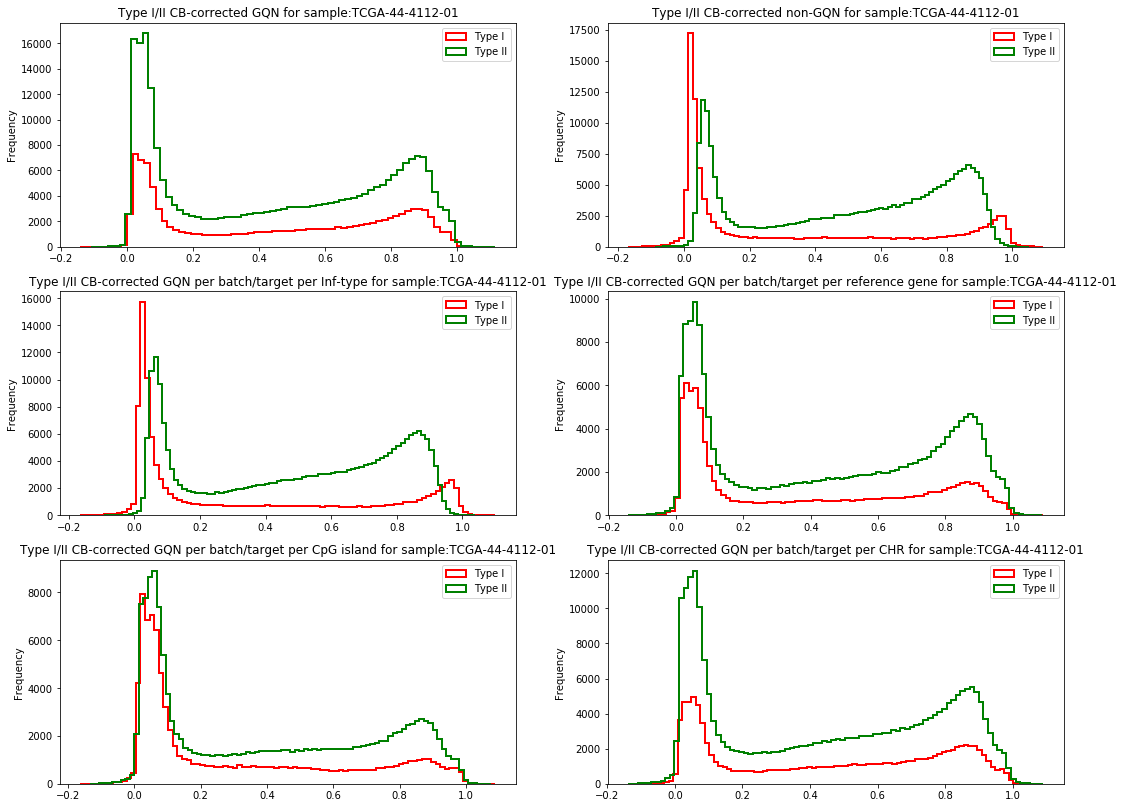

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(18,14))
_pat = 'TCGA-44-4112-01' # TCGA-22-4613-01, TCGA-86-8278-01, TCGA-44-4112-01

methylation_GQN[methylation_GQN.Infinium_Design_Type=='I'][_pat].plot.hist(bins=70, histtype='step', 
                                                    color='red', lw=2, label='Type I', ax=ax[0,0])
methylation_GQN[methylation_GQN.Infinium_Design_Type=='II'][_pat].plot.hist(bins=70, histtype='step', 
                                                    color='green', lw=2, label='Type II', ax=ax[0,0])

ax[0,0].legend()
ax[0,0].set_title('Type I/II CB-corrected GQN for sample:{}'.format(_pat))


methylation[methylation.Infinium_Design_Type=='I'][_pat].plot.hist(bins=90, histtype='step', 
                                                    color='red', lw=2, label='Type I', ax=ax[0,1])
methylation[methylation.Infinium_Design_Type=='II'][_pat].plot.hist(bins=90, histtype='step', 
                                                    color='green', lw=2, label='Type II', ax=ax[0,1])

ax[0,1].legend()
ax[0,1].set_title('Type I/II CB-corrected non-GQN for sample:{}'.format(_pat))


corrected['Infinium_Design_Type'][corrected['Infinium_Design_Type'].Infinium_Design_Type=='I'][_pat].plot.hist(bins=90, 
                                                                                                   histtype='step', 
                                                    color='red', lw=2, label='Type I', ax=ax[1,0])
corrected['Infinium_Design_Type'][corrected['Infinium_Design_Type'].Infinium_Design_Type=='II'][_pat].plot.hist(bins=90, 
                                                                                                    histtype='step', 
                                                    color='green', lw=2, label='Type II', ax=ax[1,0])

ax[1,0].legend()
ax[1,0].set_title('Type I/II CB-corrected GQN per batch/target per Inf-type for sample:{}'.format(_pat))


corrected['RefGene'][corrected['RefGene'].Infinium_Design_Type=='I'][_pat].plot.hist(bins=90, 
                                                                                                   histtype='step', 
                                                    color='red', lw=2, label='Type I', ax=ax[1,1])
corrected['RefGene'][corrected['RefGene'].Infinium_Design_Type=='II'][_pat].plot.hist(bins=90, 
                                                                                                    histtype='step', 
                                                    color='green', lw=2, label='Type II', ax=ax[1,1])

ax[1,1].legend()
ax[1,1].set_title('Type I/II CB-corrected GQN per batch/target per reference gene for sample:{}'.format(_pat))


corrected['Relation_to_UCSC_CpG_Island'][corrected['Relation_to_UCSC_CpG_Island'].Infinium_Design_Type=='I'][_pat].plot.hist(bins=90, 
                                                                                                   histtype='step', 
                                                    color='red', lw=2, label='Type I', ax=ax[2,0])
corrected['Relation_to_UCSC_CpG_Island'][corrected['Relation_to_UCSC_CpG_Island'].Infinium_Design_Type=='II'][_pat].plot.hist(bins=90, 
                                                                                                    histtype='step', 
                                                    color='green', lw=2, label='Type II', ax=ax[2,0])

ax[2,0].legend()
ax[2,0].set_title('Type I/II CB-corrected GQN per batch/target per CpG island for sample:{}'.format(_pat))

corrected['CHR'][corrected['CHR'].Infinium_Design_Type=='I'][_pat].plot.hist(bins=90, 
                                                                                                   histtype='step', 
                                                    color='red', lw=2, label='Type I', ax=ax[2,1])
corrected['CHR'][corrected['CHR'].Infinium_Design_Type=='II'][_pat].plot.hist(bins=90, 
                                                                                                    histtype='step', 
                                                    color='green', lw=2, label='Type II', ax=ax[2,1])

ax[2,1].legend()
ax[2,1].set_title('Type I/II CB-corrected GQN per batch/target per CHR for sample:{}'.format(_pat))


In [ ]:
#del methylation_globalQN
gc.collect()

In [33]:
# merge with phenotypes
pheno_features = ['batch_number', 'code.tissue_source_site', 'sample_type.samples', 'vial_number', 'ethnicity.demographic', 'gender.demographic',
                   'race.demographic', 'year_of_birth.demographic', 'diagnosis']

# Cohort bias detection

a-priori and a-posteriori


In [67]:
import rpy2.robjects as robjects
import numpy as np
from rpy2.robjects.packages import importr
preprocessCore = importr('preprocessCore')


In [68]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack'):
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    ind = df.index
    cols = ['red_'+str(i) for i in range(0,50)]
    if method=='PCA':
        X = df.loc[:, :]
        X_red = reducer.fit_transform(X)
    return pd.DataFrame(data=X_red, index=ind, columns=cols), reducer

In [69]:
gc.collect()
print('--reducing methylation without probewise normalisation--')
methylation_reduced = _dim_reduction(methylation.loc[:, pat_cols].T)
del methylation
gc.collect()

--reducing methylation without probewise normalisation--


7

In [70]:
print('--reducing methylation with GQN probewise normalisation--')
methylation_reduced_GQN = _dim_reduction(methylation_GQN.loc[:, pat_cols].T)
del methylation_GQN
gc.collect()

--reducing methylation with GQN probewise normalisation--


NameError: name 'methylation_GQN' is not defined

In [71]:
gc.collect()
corrected_reduced = {}

In [ ]:
for key in corrected.keys():
    print('--reducing methylation with probewise normalisation on {}--'.format(key))
    corrected_reduced[key] = _dim_reduction(corrected[key].loc[:, pat_cols].T)
del corrected
gc.collect()

In [ ]:
gc.collect()

methylation_raw = pd.read_table(sourceDir+"/Lung/Lung_Methylation.txt", sep="\t")
methylation_raw.set_index('probeID', inplace=True)
ind = methylation.index
print('--reducing methylation without any normalisation or cohort correction--')
methylation_reduced_raw = _dim_reduction(methylation_raw.loc[ind, pat_cols].T)

In [73]:
import  copy
corrected_reduced['combat'] = copy.copy(methylation_reduced)

In [ ]:
corrected_reduced['combat_gqn'] =  copy.copy(methylation_reduced_GQN)
corrected_reduced['combat'] = copy.copy(methylation_reduced)
del methylation_reduced, methylation_reduced_GQN
gc.collect()
corrected_reduced['raw'] =  copy.copy(methylation_reduced_raw)
del methylation_reduced_raw

In [74]:
pheno_small = pheno_small.copy().merge(pheno_large[['sample_id', 'batch_number']], how='inner', left_on='SampleID', right_on='sample_id')

In [75]:
pheno_small.set_index('sample_id', inplace=True)

In [76]:
for key in corrected_reduced.keys():
    corrected_reduced[key] = (corrected_reduced[key][0].copy().merge(pheno_small, 
                                                                       how='inner', 
                                                                       left_index=True,
                                                                       right_index=True),
                              corrected_reduced[key][1])

PC's for methylation data:combat


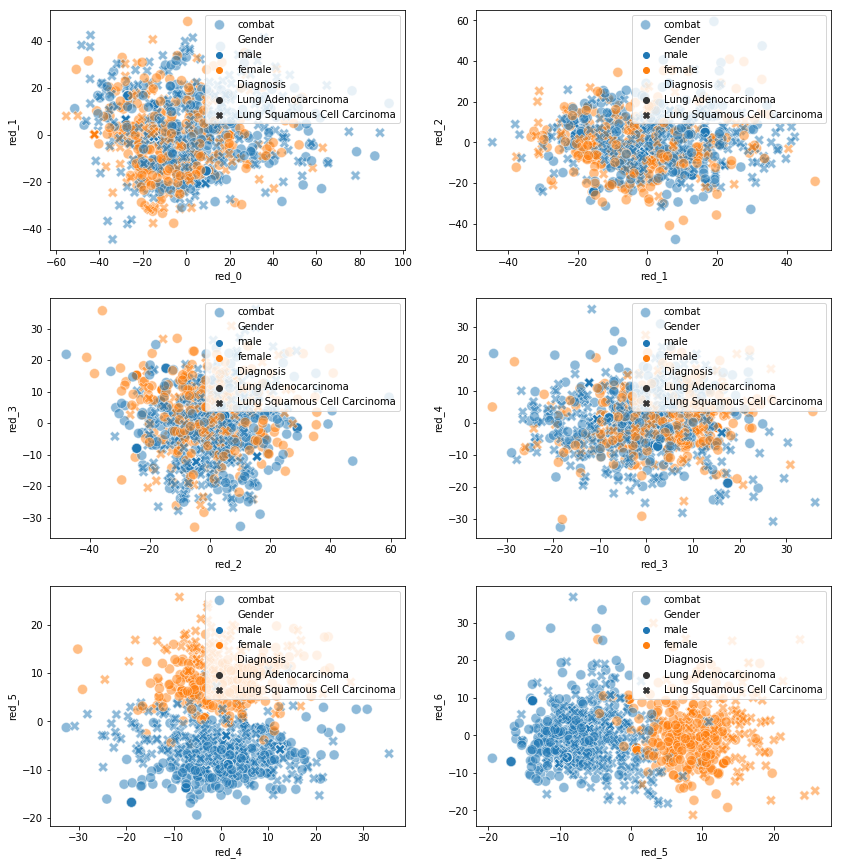

In [78]:
# check PCA, for first components, color by cancer diagnosis.
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,15))
key = 'combat' # ['Infinium_Design_Type', 'RefGene', 'Relation_to_UCSC_CpG_Island', 'CHR', 'combat', 'combat_gqn', 'raw']
color_by = 'Gender' # batch_number
size_by = None
def_size = 100
style_by = 'Diagnosis'
print('PC\'s for methylation data:{}'.format(key))
sns.scatterplot(x='red_0', y='red_1', data=corrected_reduced[key][0],
                label=key, alpha=0.5, hue=color_by, ax=ax[0,0], size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_1', y='red_2', data=corrected_reduced[key][0],
                label=key, alpha=0.5, hue=color_by, ax=ax[0,1], size=size_by, sizes=(20,100), style=style_by, s=def_size)  
sns.scatterplot(x='red_2', y='red_3', data=corrected_reduced[key][0],
                label=key, alpha=0.5, hue=color_by, ax=ax[1,0], size=size_by, sizes=(20,100), style=style_by, s=def_size)    
sns.scatterplot(x='red_3', y='red_4', data=corrected_reduced[key][0],
                label=key, alpha=0.5, hue=color_by, ax=ax[1,1], size=size_by, sizes=(20,200), style=style_by, s=def_size)    
sns.scatterplot(x='red_4', y='red_5', data=corrected_reduced[key][0],
                label=key, alpha=0.5, hue=color_by, ax=ax[2,0], size=size_by, sizes=(20,200), style=style_by, s=def_size)    
sns.scatterplot(x='red_5', y='red_6', data=corrected_reduced[key][0],
                label=key, alpha=0.5, hue=color_by, ax=ax[2,1], size=size_by, sizes=(20,200), style=style_by, s=def_size)  